# [E-18] 문자를 읽을 수 있는 딥러닝

# 0. 시작하기전..

## OCR이란?
OCR(Optical Character Recognition) : 사람이 쓰거나 기계로 인쇄한 문자의 영상을 이미지 스캐너로 획득하여 기계까 읽을 수 있는 문자로 변환하는것 

## OCR 모델
OCR은 여러가지 모델이 있다. 그 중 본프로젝트에는 3가지의 OCR 모델을 비교 분석해볼 것이다.
- Google OCR API
- keras-ocr
- Tesseract

## 구현 서비스
**해외 간판 인식 시스템**
해외 여행에 가서 지도를 따라 길은 찾아 거리에는 도착했는데 어느 건물인지 정확하게 모를때 간판들을 사진으로 찍어 어느 곳이 내가 찾는 가게인지 알려주는 서비스를 구현하려고 한다.  
이때 기본적인 글자들은 당연히 인식이 잘되어야하고 세로로된 간판들도 많기때문에 새로 글씨도 인식해야한다.  
또한 거리에 많은 간판들이 있을 수 있기 때문에 복잡한 글자들을 잘 인식해야하며 휘어진 간판도 존재하기 때문에 휘어진 글자들도 인식해야한다

## 본 프로젝트 평가 기준
1. 일반적인 사진의 글자를 잘 인식하는 가?
2. 세로로 쓰여진 글자를 잘 인식하는 가?
3. 그림과 함께 있는 복잡한 글자들을 잘 인식하는 가?
4. 휘어진 글자를 잘 인식하는 가?

# 1. 데이터 준비 

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
import cv2       
from tensorflow.keras import layers
from IPython import display
from pytesseract import Output
import matplotlib.pyplot as plt


In [2]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'
file_list = os.listdir(img_dir)
file_list.sort()
file_list

['text_image1.jpg', 'text_image2.jpg', 'text_image3.jpg', 'text_image4.jpg']

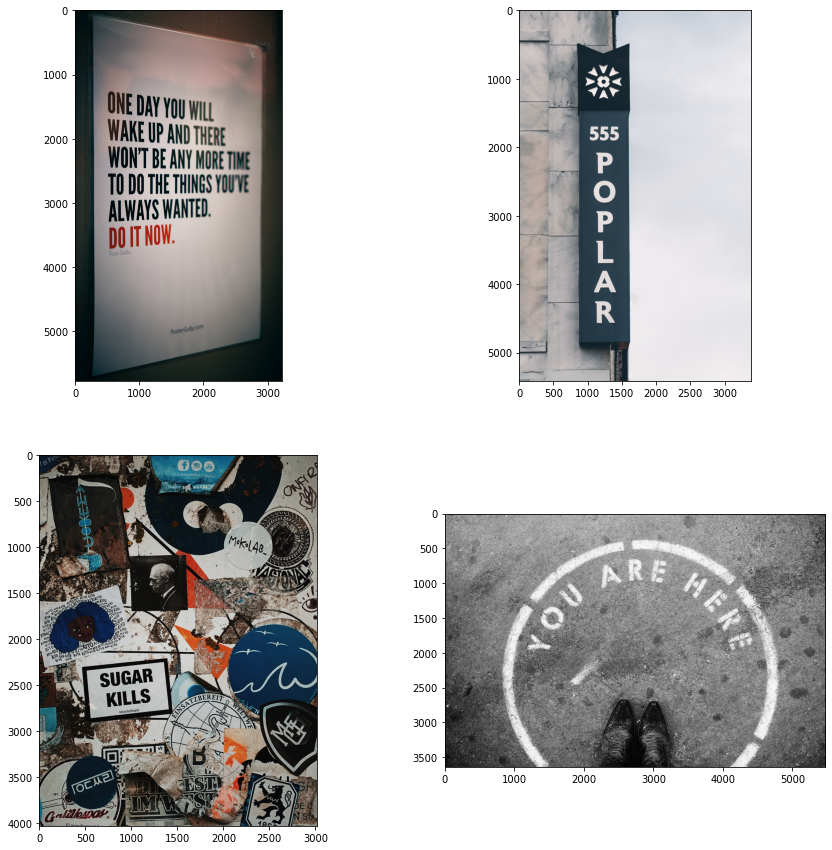

In [3]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    img = cv2.imread(os.path.join(img_dir, file_list[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

# 2. TEST

## 2.1 Google OCR

In [4]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/mythical-height-326608-aa5f556d9fd7.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    detect_text(path)
    print("-"*79)

total 1676
drwxr-xr-x 2 root root    4096 Sep 21 09:48 cropped
drwxr-xr-x 2 root root    4096 Sep 21 10:24 images
-rw-r--r-- 1 root root    2337 Sep 20 09:37 mythical-height-326608-aa5f556d9fd7.json
-rw-r--r-- 1 root root 1702230 Sep 21 10:24 Untitled.ipynb
/aiffel/aiffel/ocr_python/images/text_image1.jpg
Texts:

"ONE DAY YOU WILL
WAKE UP AND THERE
WON'T BE ANY MORE TIME
TO DO THE THINGS YOU'VE
ALWAYS WANTED.
DO IT NOW.
Paulo Coelho
PosterGully.com
"

"ONE"

"DAY"

"YOU"

"WILL"

"WAKE"

"UP"

"AND"

"THERE"

"WON'T"

"BE"

"ANY"

"MORE"

"TIME"

"TO"

"DO"

"THE"

"THINGS"

"YOU'VE"

"ALWAYS"

"WANTED."

"DO"

"IT"

"NOW."

"Paulo"

"Coelho"

"PosterGully.com"
bounds: (1468,4970),(2007,4880),(2023,4977),(1484,5067)
-------------------------------------------------------------------------------
/aiffel/aiffel/ocr_python/images/text_image2.jpg
Texts:

"555
P
R
OP
"

"555"

"P"

"R"

"OP"
bounds: (1404,2502),(1411,3203),(1098,3206),(1091,2505)
--------------------------------------------

### 2.1.2 keras-ocr

In [6]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


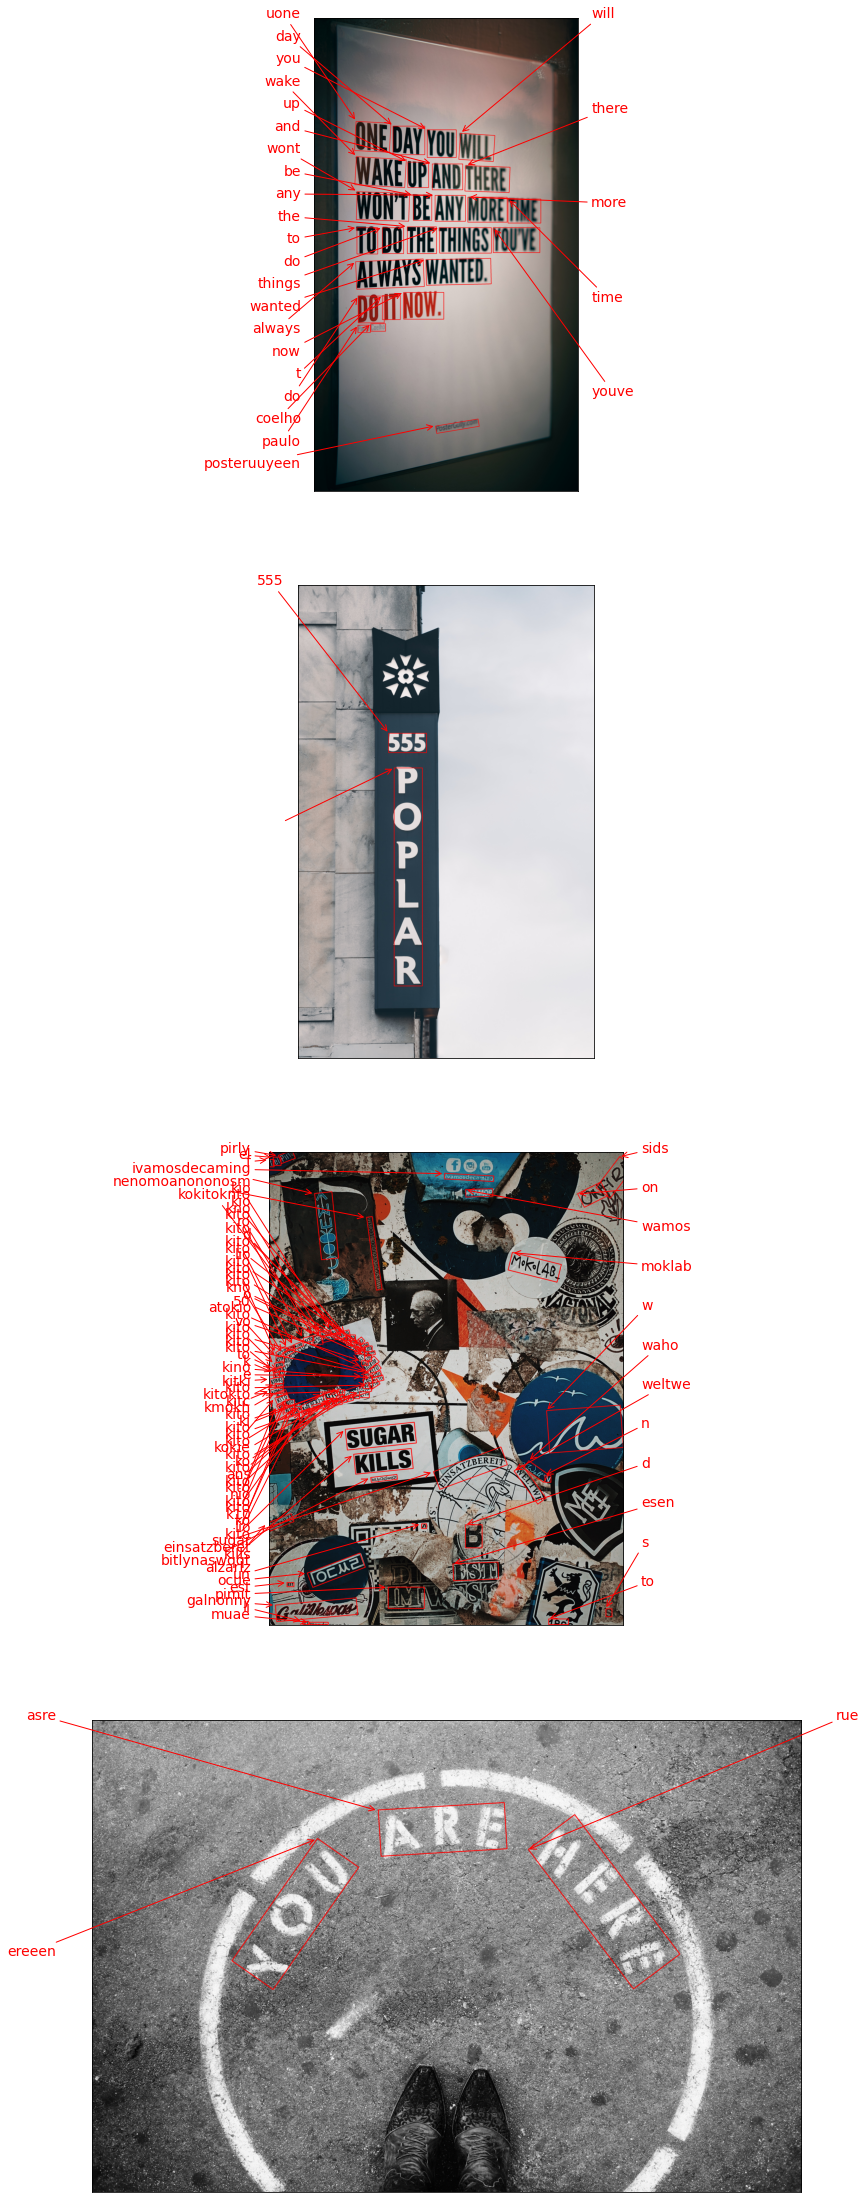

In [7]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2.1.3 Tesseract

In [8]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [9]:

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


In [10]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")


In [11]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'
for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    cropped_image_path_list=crop_word_regions(os.path.join(img_dir, file), work_dir)
    recognize_images(cropped_image_path_list)
    print("-"*79)

/aiffel/aiffel/ocr_python/images/text_image1.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png

Done
-------------------------------------------------------------------------------
/aiffel/aiffel/ocr_python/images/text_image2.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png

Done
-------------------------------------------------------------------------------
/aiffel/aiffel/ocr_python/images/text_image3.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png

Done
-------------------------------------------------------------------------------
/aiffel/aiffel/ocr_python/images/text_image4.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png

Done
-------------------------------------------------------------------------------


# 3. 테스트 결과

In [18]:
def test_result(img_path, idx):
   
    print("-"*79)
    print("Google OCR")
    detect_text(img_path)
    print("-"*79)
    print("keras-ocr")
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print("-"*79)
    print("Tesseract")
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'
    cropped_image_path_list=crop_word_regions(img_path, work_dir)
    recognize_images(cropped_image_path_list)


## 3.1 일반적인 사진

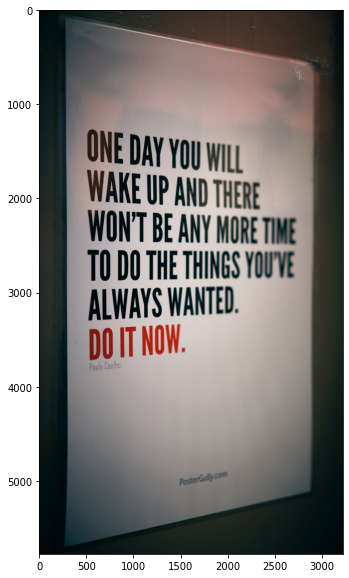

In [19]:
img_path = os.path.join(img_dir, file_list[0])
plt.figure(figsize=(10,10))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

-------------------------------------------------------------------------------
Google OCR
Texts:

"ONE DAY YOU WILL
WAKE UP AND THERE
WON'T BE ANY MORE TIME
TO DO THE THINGS YOU'VE
ALWAYS WANTED.
DO IT NOW.
Paulo Coelho
PosterGully.com
"

"ONE"

"DAY"

"YOU"

"WILL"

"WAKE"

"UP"

"AND"

"THERE"

"WON'T"

"BE"

"ANY"

"MORE"

"TIME"

"TO"

"DO"

"THE"

"THINGS"

"YOU'VE"

"ALWAYS"

"WANTED."

"DO"

"IT"

"NOW."

"Paulo"

"Coelho"

"PosterGully.com"
bounds: (1468,4970),(2007,4880),(2023,4977),(1484,5067)
-------------------------------------------------------------------------------
keras-ocr


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


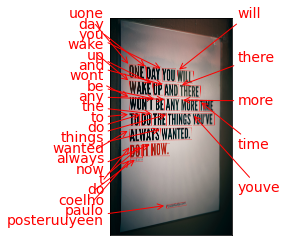

-------------------------------------------------------------------------------
Tesseract
/aiffel/aiffel/ocr_python/cropped/0000.png

Done


In [20]:
test_result(img_path,0)

## 3.2 세로 글자

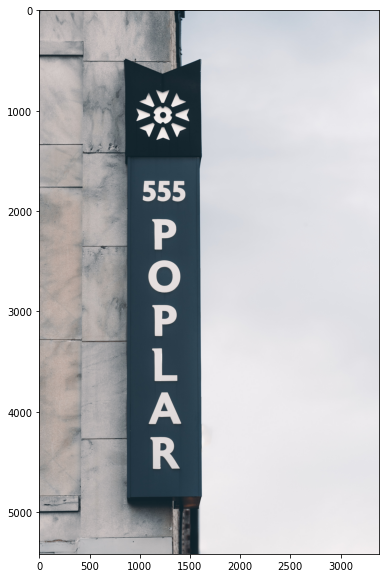

In [21]:
img_path = os.path.join(img_dir, file_list[1])
plt.figure(figsize=(10,10))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

-------------------------------------------------------------------------------
Google OCR
Texts:

"555
P
R
OP
"

"555"

"P"

"R"

"OP"
bounds: (1404,2502),(1411,3203),(1098,3206),(1091,2505)
-------------------------------------------------------------------------------
keras-ocr


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


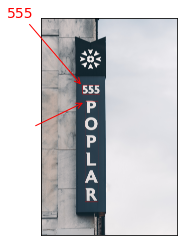

-------------------------------------------------------------------------------
Tesseract
/aiffel/aiffel/ocr_python/cropped/0000.png

Done


In [22]:
test_result(img_path,1)

## 3.3 복잡한 글자들

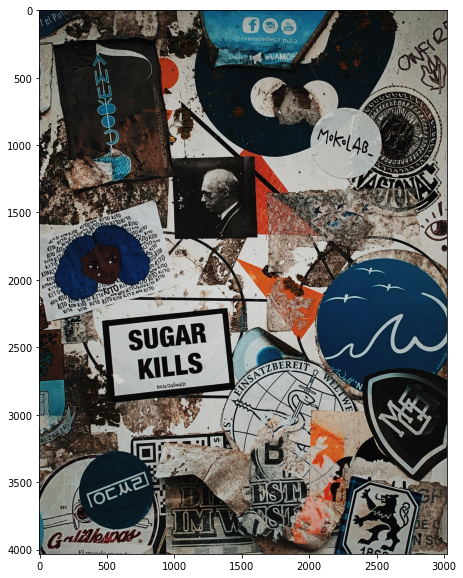

In [23]:
img_path = os.path.join(img_dir, file_list[2])
plt.figure(figsize=(10,10))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

-------------------------------------------------------------------------------
Google OCR
Texts:

"f el Pirl
You
Tule
/vamosdecamino
VAMOS
WFIR
MOKOL4B_
KITO,
KITOKITOTO
1OOKOKITO KITO
TO KITO
O AITO
KITU KITO
KITO
KITO N
KITO KIT
KITO
KTOKIT
KITO
VALTA
KITO
KTO KITO
KITO
ro KITO
KITO KITO
KTO KITO
Kne KITO KITOROITO KITO
KITO
KITO ATO,
KITO
1O Kiio KTO KITO KITO KITO KITO KITO
KITO 110
TU KITOKITO KI
SUGAR
KILLS
bit.ly/2qSwqQt
ALZARZAL
EINSA
Watt N
Diert
OCM2
EST.
EST
IMW ST
El mundo og un h
AEU
NS
186
WELTWE
SE
www.SOUNDCLOUD.COM/COREMY
OOLIN
"

"f"

"el"

"Pirl"

"You"

"Tule"

"/vamosdecamino"

"VAMOS"

"WFIR"

"MOKOL4B_"

"KITO,"

"KITOKITOTO"

"1OOKOKITO"

"KITO"

"TO"

"KITO"

"O"

"AITO"

"KITU"

"KITO"

"KITO"

"KITO"

"N"

"KITO"

"KIT"

"KITO"

"KTOKIT"

"KITO"

"VALTA"

"KITO"

"KTO"

"KITO"

"KITO"

"ro"

"KITO"

"KITO"

"KITO"

"KTO"

"KITO"

"Kne"

"KITO"

"KITOROITO"

"KITO"

"KITO"

"KITO"

"ATO,"

"KITO"

"1O"

"Kiio"

"KTO"

"KITO"

"KITO"

"KITO"

"KITO"

"KITO"

"

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


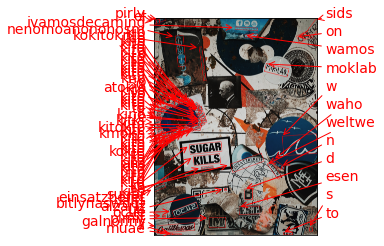

-------------------------------------------------------------------------------
Tesseract
/aiffel/aiffel/ocr_python/cropped/0000.png

Done


In [24]:
test_result(img_path,2)

## 3.4 휘어진 글자

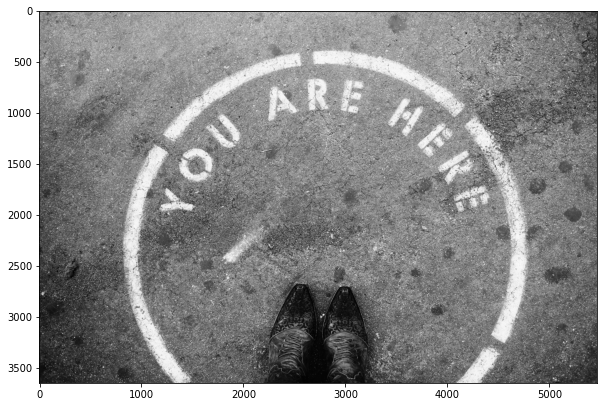

In [25]:
img_path = os.path.join(img_dir, file_list[3])
plt.figure(figsize=(10,10))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

-------------------------------------------------------------------------------
Google OCR
Texts:

"U ARE HER
HERA
大食
"

"U"

"ARE"

"HER"

"HERA"

"大"

"食"
bounds: (1028,2936),(1042,2952),(1017,2974),(1003,2959)
-------------------------------------------------------------------------------
keras-ocr


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


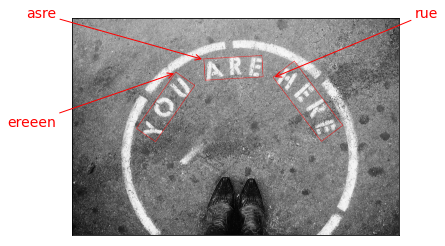

-------------------------------------------------------------------------------
Tesseract
/aiffel/aiffel/ocr_python/cropped/0000.png

Done


In [26]:
test_result(img_path,3)

# 회고

||Google|keras|Tesseract|
|-|-|-|-|
|일반 글자|O|O|X|
|새로 글자|🔺|X|X|
|복잡한 글자|O|O|X|
|휘어진 글자|🔺|X|X|

Google OCR이 가장 좋은 성능을 보였고 Tesseract는 거의 되지 않았다.  
간판은 세로로 된 간판도 있는데 이부분에 있어서 어떤 모델도 정확하게 잡아내지는 못했다.  
휘어진 글씨도 마찬가지로 인식을 잘하지 못했다. 
